### 훈련이미지셋 배경제거 (u2net_human_seg) 
https://github.com/xuebinqin/U-2-Net

U2net기반 모델의 사람 검출에 특화된 세그멘테이션 Fine-Tuning 모델을 이용하여 사람과 배경을 마스킹하고 불필요한 부분을 제거

*주의 : 매우 오랜 시간이 걸리므로 CPU자원을 최대한으로 끌어서 병렬처리를 진행

In [1]:
import os
import io
import multiprocessing
from rembg import remove, new_session
from PIL import Image
from tqdm import tqdm  # tqdm 모듈 임포트

# 배경 제거 함수
def remove_background(args):
    image_path, output_dir = args  # unpacking 인자
    # 1. 이미지 가져오기
    with open(image_path, "rb") as img_file:
        input_img = img_file.read()
    
    # 2. 배경 제거
    model_name = "u2net_human_seg"
    session = new_session(model_name)

    out = remove(input_img, session=session)

    # 3. RGBA를 흰색 배경으로 변경
    out_img = Image.open(io.BytesIO(out))  # bytes 데이터를 PIL 이미지로 변환
    
    if out_img.mode == 'RGBA':
        # 흰색 배경을 가진 새로운 이미지 생성
        background = Image.new("RGB", out_img.size, (255, 255, 255))
        # 투명한 부분을 흰색으로 채움
        background.paste(out_img, (0, 0), out_img)
        out_img = background  # 흰색 배경을 가진 이미지로 대체
    
    # 4. 저장할 경로 지정
    img_name = os.path.basename(image_path)
    output_path = os.path.join(output_dir, img_name)

    # 5. 처리된 이미지 저장
    out_img.save(output_path, format='JPEG')  # JPEG로 저장

# 병렬 처리 함수
def process_images_in_parallel(image_paths, output_dir, num_workers=4):
    # 출력 디렉토리가 없다면 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 멀티프로세싱 풀 생성
    pool = multiprocessing.Pool(num_workers)
    
    # tqdm을 사용하여 진행 상황 표시
    # 각 인자를 튜플로 전달
    for _ in tqdm(pool.imap(remove_background, [(image_path, output_dir) for image_path in image_paths]), total=len(image_paths)):
        pass
    
    # 풀 종료
    pool.close()
    pool.join()

if __name__ == "__main__":
    # 이미지 파일이 들어 있는 디렉토리와 출력 디렉토리 설정
    input_dir = './data/training_image'  # 처리할 이미지가 있는 디렉토리
    output_dir = './data/training_image_rembg'   # 처리된 이미지 저장할 디렉토리
    
    # 입력 디렉토리 내 모든 이미지 파일 경로 리스트 만들기
    image_paths = [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]
    
    # 병렬로 이미지 처리 (CPU 코어 수에 따라 조정 가능)
    process_images_in_parallel(image_paths, output_dir, num_workers=50)


100%|██████████| 4070/4070 [39:03<00:00,  1.74it/s]  


### 처리 이미지 정합성 확인

훈련데이터 갯수와 처리된 이미지의 수가 맞는지 확인하고, 도중에 중단되거나 오류가 있는 파일이 없는지 확인

In [2]:
import os
import sys

def get_file_list(path):
    file_list = []
    for root, dirs, files in os.walk(path):
        for file in files:
            file_list.append(file)
    return file_list

training_image_list = get_file_list('data/training_image')
print(len(training_image_list))
rembg_image_list = get_file_list('data/training_image_rembg')
print(len(training_image_list))

4070
4070


In [30]:
import os
from PIL import Image

def find_corrupted_images(input_dir):
    corrupted_images = []
    
    # 입력 디렉토리 내 모든 이미지 파일 경로 리스트 만들기
    image_paths = [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]
    
    for image_path in image_paths:
        try:
            # 이미지 열기 (손상된 파일일 경우 예외 발생)
            with Image.open(image_path) as img:
                img.verify()  # 이미지 파일 검증
        except Exception as e:
            # 손상된 이미지 목록에 추가
            image_name  = os.path.basename(image_path)
            corrupted_images.append((image_name))
    
    return corrupted_images

if __name__ == "__main__":
    input_dir = './data/training_image_rembg'  # 손상된 파일을 확인할 디렉토리
    corrupted_images = find_corrupted_images(input_dir)
    
    if corrupted_images:
        print("손상된 이미지 파일:")
        for img_path in corrupted_images:
            print(f"{img_path}")
    else:
        print("손상된 이미지 파일이 없습니다.")

손상된 이미지 파일:
T_14085_19_genderless_W.jpg
W_04781_50_feminine_W.jpg
W_00882_19_normcore_M.jpg
W_38629_80_powersuit_W.jpg
W_24530_70_hippie_M.jpg
W_13431_19_normcore_W.jpg
W_13281_60_minimal_W.jpg
T_07897_00_cityglam_W.jpg
W_24309_50_ivy_M.jpg


### 처리중 손상된 이미지 재처리

In [31]:

input_dir = './data/training_image'  # 처리할 원본 이미지가 있는 디렉토리
output_dir = './data/training_image_rembg'   # 처리된 이미지 저장할 디렉토리

# output_dir에서 손상된 파일 리스트 찾기
corrupted_images = find_corrupted_images(output_dir)
print(f"손상된 파일 수: {len(corrupted_images)}")
# 손상된 파일 리스트를 기준으로 input_dir의 파일 경로 리스트 만들기
valid_image_paths = [os.path.join(input_dir, fname) for fname in corrupted_images if os.path.exists(os.path.join(input_dir, fname))]
# # 손상된 파일만 다시 처리
if valid_image_paths:
    process_images_in_parallel(valid_image_paths, output_dir, num_workers=4)



손상된 파일 수: 9


100%|██████████| 9/9 [00:12<00:00,  1.38s/it]


In [32]:
corrupted_images = find_corrupted_images(output_dir)
print(f"손상된 파일 수: {len(corrupted_images)}")


손상된 파일 수: 0


### 배경 제거 결과 후처리
배경을 제거하면서 잘못된 검출로 패션 데이터도 지워버릴 수 있기때문에 검증 필요.

배경을 제거하고 흰색을 마스킹했기때문에 이미지에서 흰색 픽셀의 비율을 검출해 과다하게 많은 배경이 검출되는지 확인(90%) 

In [5]:
import os
import numpy as np
from PIL import Image
import multiprocessing
from tqdm import tqdm

def is_anomalous(image_path, threshold=0.9):
    """
    배경 제거된 이미지에서 흰색 픽셀이 차지하는 비율이 특정 임계값을 넘으면 True를 반환.
    """
    image = Image.open(image_path).convert('RGB')  # 이미지 열기
    image_np = np.array(image)  # 이미지를 NumPy 배열로 변환

    # 흰색 픽셀 (255, 255, 255) 탐지
    white_pixels = np.all(image_np == [255, 255, 255], axis=-1)
    
    # 흰색 픽셀 비율 계산
    white_ratio = np.mean(white_pixels)
    
    return image_path if white_ratio > threshold else None  # 임계값 초과 시 이상치로 판단

def process_image(image_path_threshold_tuple):
    """
    Tuple을 받아 is_anomalous를 실행하는 함수. 
    multiprocessing을 사용할 때 필요.
    """
    image_path, threshold = image_path_threshold_tuple
    return is_anomalous(image_path, threshold)

def find_anomalous_images_parallel(image_paths, threshold=0.9, num_workers=4):
    """
    병렬로 이상치 이미지를 찾는 함수. tqdm으로 진행 상황을 표시.
    """
    # 각 이미지 경로와 threshold를 튜플로 묶어서 전달
    path_threshold_tuples = [(img, threshold) for img in image_paths]
    
    with multiprocessing.Pool(num_workers) as pool:
        # tqdm으로 병렬처리 진행 상황 표시
        results = list(tqdm(pool.imap(process_image, path_threshold_tuples), 
                            total=len(image_paths), desc="Checking for anomalies"))
    
    # 이상치 이미지만 필터링
    anomalous_images = [res for res in results if res is not None]
    
    return anomalous_images

def calculate_white_pixel_percentage(image_path):
    """
    단일 이미지에서 하얀색 픽셀이 차지하는 비율을 계산하는 함수.
    
    Args:
        image_path (str): 이미지 파일 경로
        
    Returns:
        float: 하얀색 픽셀 비율 (0.0 ~ 1.0)
    """
    # 이미지 열기 및 RGB로 변환
    image = Image.open(image_path).convert('RGB')
    
    # 이미지를 NumPy 배열로 변환
    image_np = np.array(image)
    
    # 흰색 픽셀 (255, 255, 255) 탐지
    white_pixels = np.all(image_np == [255, 255, 255], axis=-1)
    
    # 흰색 픽셀 비율 계산
    white_ratio = np.mean(white_pixels)
    
    return white_ratio


if __name__ == "__main__":
    # 배경 제거된 이미지가 저장된 디렉토리
    output_dir = './data/training_image_rembg'

    # 디렉토리 내 모든 이미지 파일 경로 리스트 만들기
    image_paths = [os.path.join(output_dir, fname) for fname in os.listdir(output_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]
    
    # 병렬로 이상치 탐지 (임계값과 워커 수는 필요에 따라 조정 가능)
    anomalies = find_anomalous_images_parallel(image_paths, threshold=0.79, num_workers=50)
    
    # 이상치로 판단된 이미지 출력
    if anomalies:
        print("Anomalous images found:", len(anomalies))
    else:
        print("No anomalies found.")


Checking for anomalies: 100%|██████████| 4070/4070 [00:40<00:00, 101.68it/s]

Anomalous images found: 1013


### 이상 데이터 확인

직접 데이터를 확인해봤는데, 배경과 사람은 올바르게 분리됬지만 사람이 배경에 비해 많이 작을경우 이 방식으로도 검출되어서
이상치를 완벽히 탐색하긴 어려움.

In [48]:
anomalies

['./data/training_image_rembg/W_07271_10_sportivecasual_M.jpg',
 './data/training_image_rembg/W_24352_70_hippie_M.jpg',
 './data/training_image_rembg/W_01154_10_athleisure_W.jpg',
 './data/training_image_rembg/W_07418_50_feminine_W.jpg',
 './data/training_image_rembg/W_09008_10_sportivecasual_W.jpg',
 './data/training_image_rembg/W_09533_90_grunge_W.jpg',
 './data/training_image_rembg/W_11726_50_feminine_W.jpg',
 './data/training_image_rembg/W_11538_90_kitsch_W.jpg',
 './data/training_image_rembg/W_07344_10_sportivecasual_M.jpg',
 './data/training_image_rembg/W_14310_80_powersuit_W.jpg',
 './data/training_image_rembg/W_02060_10_athleisure_W.jpg',
 './data/training_image_rembg/W_02170_50_feminine_W.jpg',
 './data/training_image_rembg/W_08040_90_kitsch_W.jpg',
 './data/training_image_rembg/T_08918_19_normcore_W.jpg',
 './data/training_image_rembg/W_04319_90_hiphop_M.jpg',
 './data/training_image_rembg/W_04994_60_popart_W.jpg',
 './data/training_image_rembg/W_07759_00_cityglam_W.jpg',
 '.

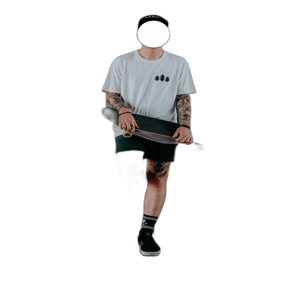

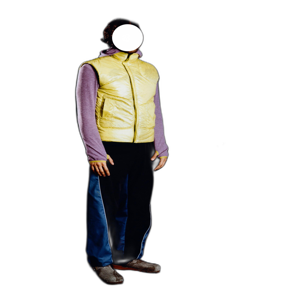

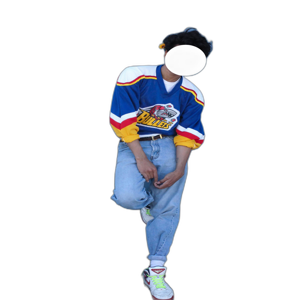

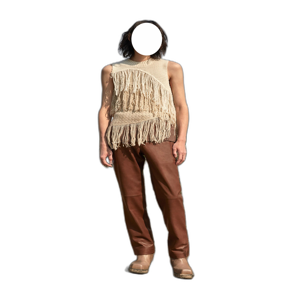

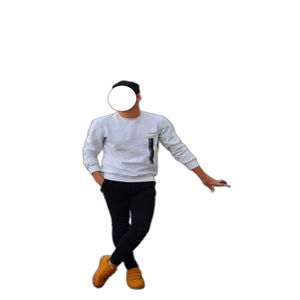

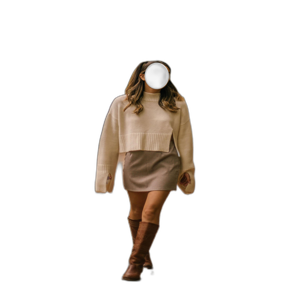

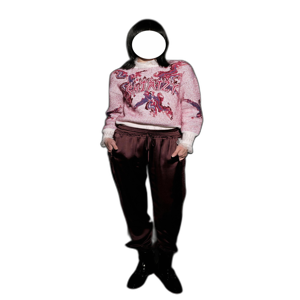

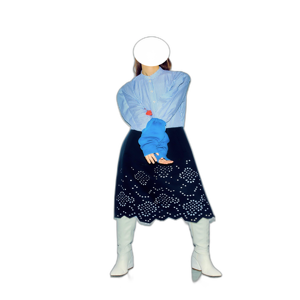

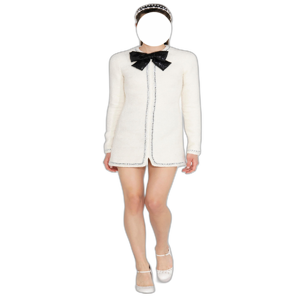

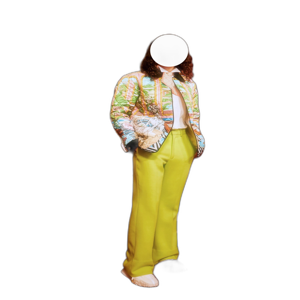

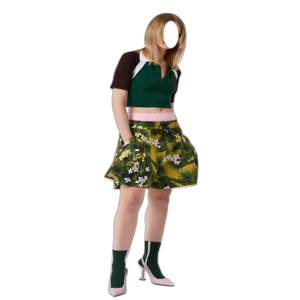

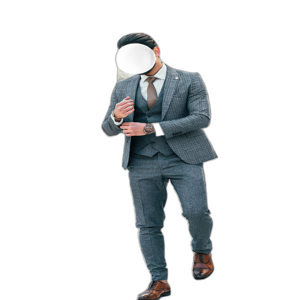

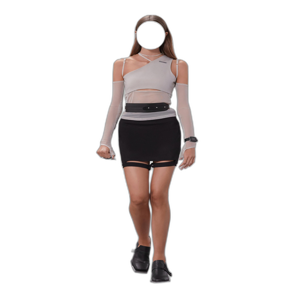

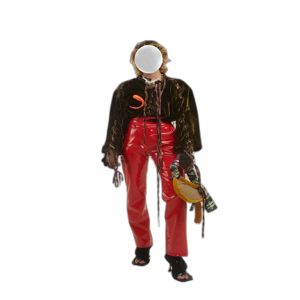

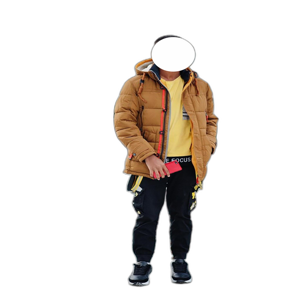

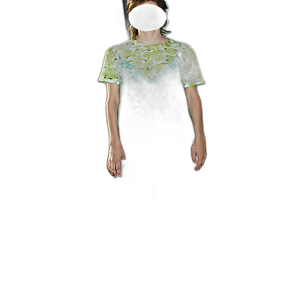

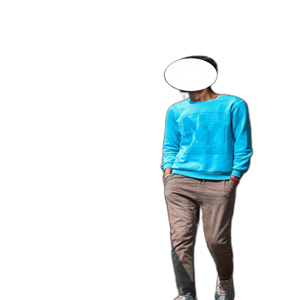

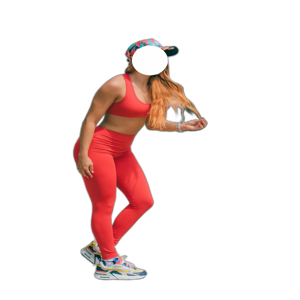

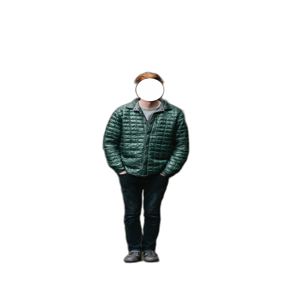

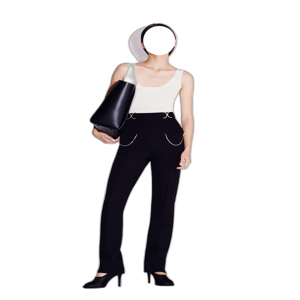

In [6]:
from IPython.display import display, Image
from PIL import Image as PILImage

# 이미지 표시
for path in anomalies[:20]:
    img = PILImage.open(path)  # 이미지 열기
    img = img.resize((300, 300))  # 이미지 리사이징 (300x300)
    display(img)  # 이미지 표시


### 배경 처리 고도화 모델 적용

U2net기반의 모델보다 훨씬 좋은 성과를 보이고 있는 birefnet 구조의 사람 영역 추출용 Tuning모델을 사용해보았다.

훈련데이터 전체에 적용해보고 싶지만, 좋은만큼 무거운 모델이라 23장 처리에 4분이 걸리고 CPU모델이 아닌 GPU모델이기에 병렬 계산이 어렵다.

U2net 모델은 훨씬 가볍고 일반적인 배경 제거 성능도 나쁘지 않기때문에 결과에서 이상한 점을 탐색하여 고수준 모델을 돌리는 것이 나을 것 같다.

In [55]:
import os
import io
from rembg import remove, new_session
from PIL import Image
def remove_background_single(image_path, output_dir, session):
    # 1. 이미지 가져오기
    with open(image_path, "rb") as img_file:
        input_img = img_file.read()
        
    # 2. 배경 제거
    out = remove(input_img, session=session)

    # 3. RGBA를 흰색 배경으로 변경
    out_img = Image.open(io.BytesIO(out))  # bytes 데이터를 PIL 이미지로 변환
    
    if out_img.mode == 'RGBA':
        # 흰색 배경을 가진 새로운 이미지 생성
        background = Image.new("RGB", out_img.size, (255, 255, 255))
        # 투명한 부분을 흰색으로 채움
        background.paste(out_img, (0, 0), out_img)
        out_img = background  # 흰색 배경을 가진 이미지로 대체
    
    # 4. 저장할 경로 지정
    img_name = os.path.basename(image_path)
    output_path = os.path.join(output_dir, img_name)

    # 5. 처리된 이미지 저장
    out_img.save(output_path, format='JPEG')  # JPEG로 저장

if __name__ == "__main__":
    # 단일 이미지 파일 경로와 출력 디렉토리 지정
    output_dir = './data/training_image_rembg_anormal'              # 저장할 디렉토리

    # 출력 디렉토리가 없다면 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 배경 제거 및 처리된 이미지 저장
    model_name = "birefnet-portrait"
    session = new_session(model_name)
    anomal_train_path = [path.replace('training_image_rembg', 'training_image') for path in anomalies]
    for image_path in tqdm(anomal_train_path):
        remove_background_single(image_path, output_dir, session=session)

100%|██████████| 23/23 [04:22<00:00, 11.41s/it]


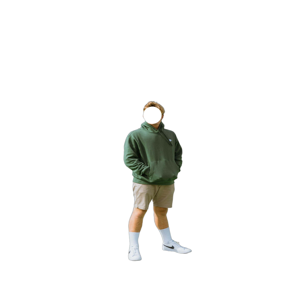

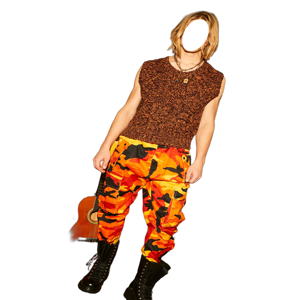

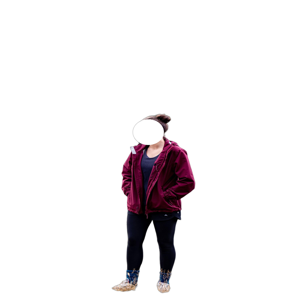

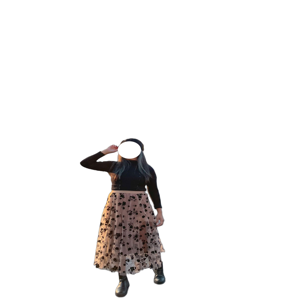

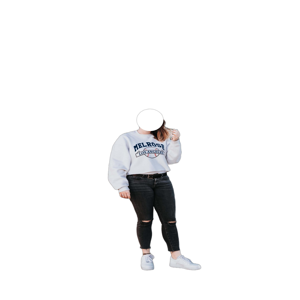

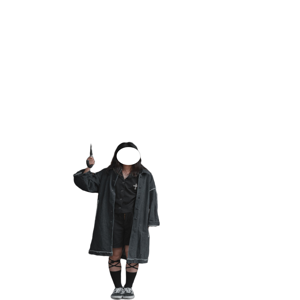

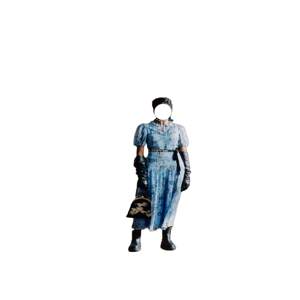

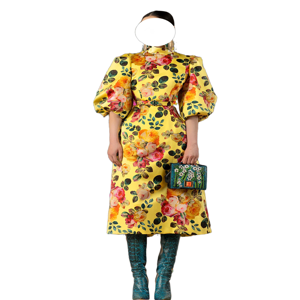

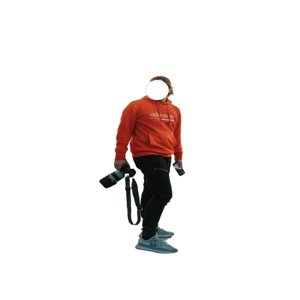

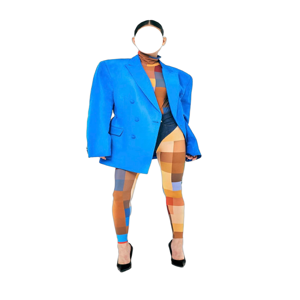

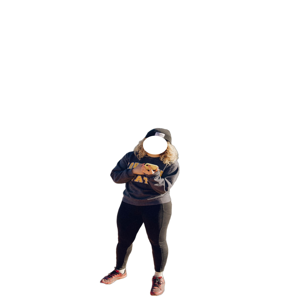

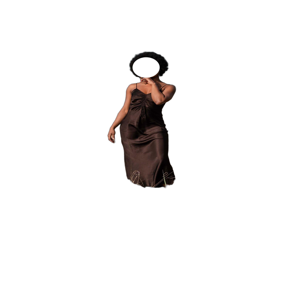

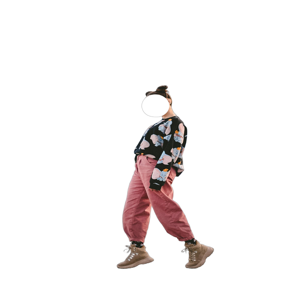

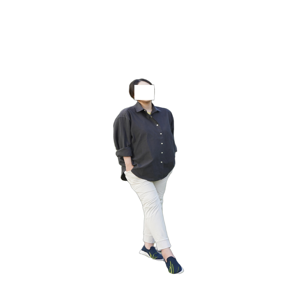

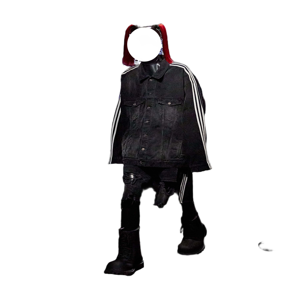

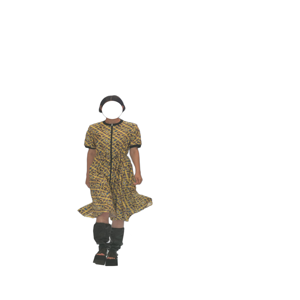

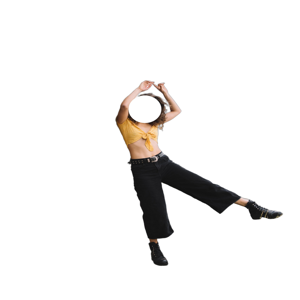

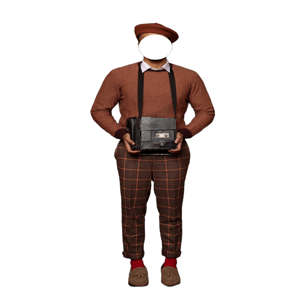

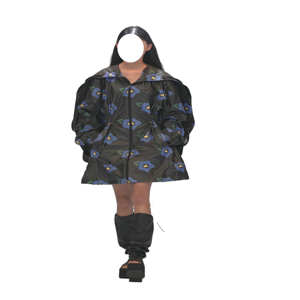

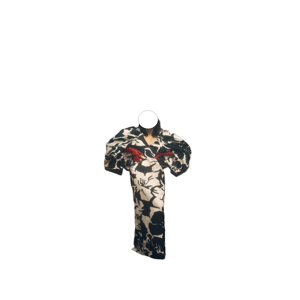

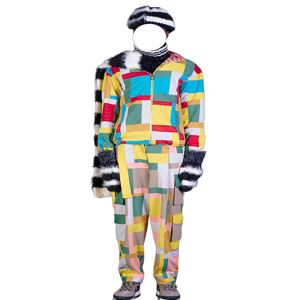

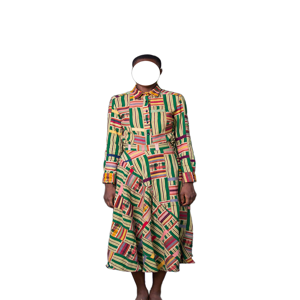

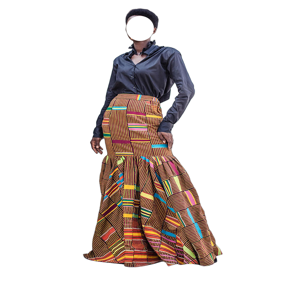

In [58]:
from IPython.display import display, Image
from PIL import Image as PILImage

# 이미지 표시
input_dir = './data/training_image_rembg_anormal'
image_paths = [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]
for path in image_paths:
    img = PILImage.open(path)  # 이미지 열기
    img = img.resize((300, 300))  # 이미지 리사이징 (300x300)
    display(img)  # 이미지 표시

In [59]:
import os
import shutil

# 경로 설정
source_folder = './data/training_image_rembg_anormal'
destination_folder = './data/training_image_rembg'

# 소스 폴더의 모든 파일을 대상 폴더에 복사
for filename in os.listdir(source_folder):
    source_file = os.path.join(source_folder, filename)
    destination_file = os.path.join(destination_folder, filename)
    
    # 파일이 존재하면 덮어쓰기
    if os.path.isfile(source_file):
        shutil.copyfile(source_file, destination_file)
        print(f"'{source_file}'를 '{destination_file}'에 덮어썼습니다.")


'./data/training_image_rembg_anormal/W_07271_10_sportivecasual_M.jpg'를 './data/training_image_rembg/W_07271_10_sportivecasual_M.jpg'에 덮어썼습니다.
'./data/training_image_rembg_anormal/W_24352_70_hippie_M.jpg'를 './data/training_image_rembg/W_24352_70_hippie_M.jpg'에 덮어썼습니다.
'./data/training_image_rembg_anormal/W_01154_10_athleisure_W.jpg'를 './data/training_image_rembg/W_01154_10_athleisure_W.jpg'에 덮어썼습니다.
'./data/training_image_rembg_anormal/W_07418_50_feminine_W.jpg'를 './data/training_image_rembg/W_07418_50_feminine_W.jpg'에 덮어썼습니다.
'./data/training_image_rembg_anormal/W_09008_10_sportivecasual_W.jpg'를 './data/training_image_rembg/W_09008_10_sportivecasual_W.jpg'에 덮어썼습니다.
'./data/training_image_rembg_anormal/W_09533_90_grunge_W.jpg'를 './data/training_image_rembg/W_09533_90_grunge_W.jpg'에 덮어썼습니다.
'./data/training_image_rembg_anormal/W_11726_50_feminine_W.jpg'를 './data/training_image_rembg/W_11726_50_feminine_W.jpg'에 덮어썼습니다.
'./data/training_image_rembg_anormal/W_11538_90_kitsch_W.jpg'를 './data

In [60]:
import cv2
import numpy as np
import os
from PIL import Image

def extract_bounding_box(image_path, output_dir):
    # 이미지 불러오기
    img = cv2.imread(image_path)
    
    # 흰색 배경을 더 정확하게 인식하기 위해 inRange 사용
    lower_white = np.array([200, 200, 200], dtype=np.uint8)
    upper_white = np.array([255, 255, 255], dtype=np.uint8)
    
    # 흰색 배경 제외한 마스크 생성
    mask = cv2.inRange(img, lower_white, upper_white)
    mask_inv = cv2.bitwise_not(mask)  # 흰색 배경 제외한 부분만 남김
    
    # 바운딩 박스 좌표 계산
    contours, _ = cv2.findContours(mask_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        print(f"인물 영역을 찾지 못했습니다: {image_path}")
        return
    
    # 여러 개의 바운딩 박스를 처리하기 위해 모든 컨투어에서 가장 큰 사각형 찾기
    x_min, y_min, x_max, y_max = np.inf, np.inf, 0, 0
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        x_min = min(x_min, x)
        y_min = min(y_min, y)
        x_max = max(x_max, x + w)
        y_max = max(y_max, y + h)
    
    # 원본 이미지에서 해당 바운딩 박스 영역만 crop
    cropped_img = img[y_min:y_max, x_min:x_max]
    
    # 출력 디렉토리 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 잘라낸 이미지 저장 경로 설정
    img_name = os.path.basename(image_path).split('.')[0]
    output_path = os.path.join(output_dir, f"{img_name}.jpg")
    
    # 잘라낸 이미지 저장
    cv2.imwrite(output_path, cropped_img)

if __name__ == "__main__":
    input_dir = './data/training_image_rembg'  # 처리할 이미지가 있는 디렉토리
    output_dir = './data/training_image_cropped'  # 잘라낸 이미지 저장 디렉토리
    
    # 입력 디렉토리 내 모든 이미지 파일 경로 리스트 만들기
    image_paths = [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]
    # 모든 이미지에서 인물 부분만 잘라내기
    for image_path in tqdm(image_paths):
        extract_bounding_box(image_path, output_dir)

100%|██████████| 4070/4070 [03:33<00:00, 19.04it/s]
